In [1]:
import synapseclient
from synapseclient import Project, File, Folder
from synapseclient import Schema, Column, Table, Row, RowSet, as_table_columns
import itertools
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from upsetplot import UpSet
from upsetplot import from_memberships
from upsetplot import plot

In [2]:
syn = synapseclient.Synapse()
syn.login()

Welcome, Abby Vander Linden!



Get biospecimen metadata files from ROSMAP satellite studies.

In [3]:
divco_bio = pd.read_csv(syn.get('syn51757645').path, dtype = {'individualID': 'str'})
rosmap_bio = pd.read_csv(syn.get('syn21323366').path, dtype = {'individualID': 'str'})
mayo_bio = pd.read_csv(syn.get('syn20827192').path, dtype = {'individualID': 'str'})
msbb_bio = pd.read_csv(syn.get('syn21893059').path, dtype = {'individualID': 'str'})
nps_bio = pd.read_csv(syn.get('syn55251032').path, dtype = {'individualID': 'str'})
lipid_bio = pd.read_csv(syn.get('syn26475187').path, dtype = {'individualID': 'str'})
#cogres_bio = pd.read_csv(syn.get('syn24185681').path, dtype = {'individualID': 'str'})

In [4]:
rosmap_bio['specimenMetadataSource'] = "ROSMAP"
mayo_bio['specimenMetadataSource'] = "Mayo"
msbb_bio['specimenMetadataSource'] = "MSBB"
nps_bio['specimenMetadataSource'] = "NPS-AD"
lipid_bio['specimenMetadataSource'] = "ROSMAP_Lipidomics_Emory"
#cogres_bio['specimenMetadataSource'] = "ROSMAP_CogRes"

Combine data frames.

In [6]:
mega_bio = pd.concat([divco_bio, rosmap_bio, mayo_bio, msbb_bio, nps_bio, lipid_bio], ignore_index=True)

In [7]:
mega_bio = mega_bio[['individualID', 'specimenID', 'specimenMetadataSource', 'organ', 'tissue', 'assay', 'nucleicAcidSource', 'cellType']]

There are 94 distinct specimens that are missing individualID -- discard.

In [162]:
mega_bio.loc[mega_bio['individualID'].isna()]['specimenID'].unique().size

94

In [8]:
clean_bio = mega_bio.dropna(subset = ['individualID'])
clean_bio = clean_bio.dropna(subset = ['specimenID'])
clean_bio = clean_bio[clean_bio['individualID'] != 'GISpool']

In [9]:
clean_bio.loc[clean_bio['individualID'] == '1005']

,individualID,specimenID,specimenMetadataSource,organ,tissue,assay,nucleicAcidSource,cellType
299,1005,1005_DLPFC,AMP-AD_DiverseCohorts,brain,dorsolateral prefrontal cortex,rnaSeq,bulk cell,NaN
300,1005,1005_TCX,AMP-AD_DiverseCohorts,brain,superior temporal gyrus,rnaSeq,bulk cell,NaN
3410,1005,mayo_b02.134C,AMP-AD_DiverseCohorts,brain,dorsolateral prefrontal cortex,TMT quantitation,not applicable,NaN
4432,1005,b12.133N,AMP-AD_DiverseCohorts,brain,superior temporal gyrus,TMT quantitation,not applicable,NaN
18358,1005,1005_TCX,Mayo,brain,temporal cortex,rnaSeq,bulk cell,NaN
18955,1005,1005,Mayo,brain,temporal cortex,wholeGenomeSeq,NaN,NaN
19281,1005,1005,Mayo,brain,temporal cortex,snpArray,NaN,NaN
19713,1005,b5_013,Mayo,brain,temporal cortex,label free mass spectrometry,bulk cell,NaN


In [10]:
clean_bio['unique_specimenID'] = clean_bio['specimenID'] + "_" + clean_bio['specimenMetadataSource'] + "_" + clean_bio['assay']

In [168]:
len(clean_bio['unique_specimenID'].unique()) == len(clean_bio['unique_specimenID'])


True

Get individual metadata files 

In [12]:
rosmap_ind = pd.read_csv(syn.get('syn3191087').path, dtype = {'individualID': 'str'})
msbb_ind = pd.read_csv(syn.get('syn6101474').path, dtype = {'individualID': 'str'})
mayo_ind = pd.read_csv(syn.get('syn23277389').path, dtype = {'individualID': 'str'})
divco_ind = pd.read_csv(syn.get('syn51757646').path, dtype = {'individualID': 'str'})
nps_ind = pd.read_csv(syn.get('syn55251012').path, dtype = {'individualID': 'str'})

In [13]:
rosmap_ind['Study'] = 'ROSMAP'
msbb_ind['Study'] = 'MSBB'
mayo_ind['Study'] = 'Mayo'
divco_ind['Study'] = 'Diverse Cohorts'
nps_ind['Study'] = 'NPS-AD'

In [14]:
mega_ind = pd.concat([rosmap_ind, msbb_ind, mayo_ind, divco_ind, nps_ind])
mega_ind = mega_ind[['individualID', 'cohort', 'individualIdSource', 'Study']]


In [15]:
mega_ind['new_cohort'] = mega_ind['cohort']
mega_ind.loc[mega_ind['Study'] == 'ROSMAP', 'new_cohort'] = 'ROSMAP'
mega_ind.loc[(mega_ind['cohort'].isnull()) & (mega_ind['Study'] == 'Mayo'), 'new_cohort'] = 'Mayo Clinic'
mega_ind.loc[(mega_ind['cohort'].isnull()) & (mega_ind['Study'] == 'MSBB'), 'new_cohort'] = 'MSBB'
mega_ind.loc[mega_ind['cohort'] == 'Mt Sinai Brain Bank', 'new_cohort'] = 'MSBB'
mega_ind.loc[(mega_ind['cohort'] == 'ROS') | (mega_ind['cohort'] =='MAP'), 'new_cohort'] = 'ROSMAP'

In [16]:
clean_ind = mega_ind[['individualID', 'new_cohort']]
clean_ind = clean_ind.drop_duplicates()
clean_ind = clean_ind.dropna()

In [17]:
oops = clean_ind.groupby(['individualID']).count().sort_values('new_cohort', ascending = False)
oops_ids = oops[oops['new_cohort'] > 1].reset_index()

In [18]:
overlaps = clean_ind[clean_ind['individualID'].isin(oops_ids['individualID'])]


In [19]:
all_mars = overlaps.loc[overlaps['new_cohort']== 'MARS']
all_clincor = overlaps.loc[overlaps['new_cohort'] == 'CLINCOR']
all_latc = overlaps.loc[overlaps['new_cohort'] == 'LATC']
all_banner = overlaps.loc[overlaps['new_cohort'] == 'Banner']

In [20]:
clean_ind.loc[clean_ind['individualID'].isin(all_mars['individualID']), 'new_cohort'] = 'MARS'
clean_ind.loc[clean_ind['individualID'].isin(all_clincor['individualID']), 'new_cohort'] = "CLINCOR"
clean_ind.loc[clean_ind['individualID'].isin(all_latc['individualID']), 'new_cohort'] = "LATC"
clean_ind.loc[clean_ind['individualID'].isin(all_banner['individualID']), 'new_cohort'] = "Banner"
clean_ind = clean_ind.drop_duplicates()

In [21]:
len(clean_ind['individualID'].unique()) == len(clean_ind['individualID'])

False

In [22]:
# join to the biospecimen data frame
# 7 specimens lost during inner join, worry about it later
joined_df = clean_bio.merge(clean_ind, how = "inner", on = "individualID")

In [23]:
# all the rows where organ is na are WGS/WES/genotyping -- we can assume all are brain for now
joined_df.loc[joined_df['organ'].isna(), 'assay'] = 'brain'

Create simplified assay column

In [24]:
joined_df['simplified_assay'] = joined_df['assay']
joined_df.loc[(joined_df['organ'] == 'blood') & (joined_df['assay'] == 'Biocrates p180'), 'simplified_assay'] = 'plasma Biocrates p180'
joined_df.loc[(joined_df['organ'] == 'brain') & (joined_df['assay'] == 'Biocrates p180'), 'simplified_assay'] = 'brain Biocrates p180'
joined_df.loc[(joined_df['organ'] == 'brain') & (joined_df['assay'] == 'Biocrates p180'), 'simplified_assay'] = 'brain Biocrates bile acids'
joined_df.loc[(joined_df['organ'] == 'blood') & (joined_df['assay'] == 'LC-MSMS'), 'simplified_assay'] = 'plasma lipidomics'
joined_df.loc[(joined_df['organ'] == 'brain') & (joined_df['assay'] == 'LC-MSMS'), 'simplified_assay'] = 'brain lipidomics'
joined_df.loc[(joined_df['organ'] == 'brain') & (joined_df['assay'] == 'LC-MSMS'), 'simplified_assay'] = 'brain lipidomics'
joined_df.loc[(joined_df['organ'] == 'brain') & (joined_df['assay'] == 'Metabolon'), 'simplified_assay'] = 'brain Metabolon'
joined_df.loc[joined_df['assay'] == 'LC-MSMS', 'simplified_assay'] = 'plasma lipidomics'
joined_df.loc[joined_df['assay'].str.contains('ATAC'), 'simplified_assay'] = 'ATACseq'
joined_df.loc[joined_df['assay'] == 'label free mass spectrometry', 'simplified_assay'] = 'SRM targeted proteomics'
joined_df.loc[joined_df['assay'].isin(['scrnaSeq', 'snrnaSeq']), 'simplified_assay'] = 'sc/snRNAseq'


In [25]:
joined_df.groupby(['simplified_assay']).size()

simplified_assay
10x multiome                   399
ATACseq                        746
Biocrates Bile Acids           111
ChIPSeq                        712
SRM targeted proteomics       1694
TMT quantitation              2183
brain                         2455
brain Biocrates bile acids     111
brain Metabolon                894
exomeSeq                       343
methylationArray               941
mirnaArray                     748
plasma Biocrates p180          597
plasma lipidomics             1058
rnaArray                       492
rnaSeq                        7402
sc/snRNAseq                   2489
snpArray                       305
wholeGenomeSeq                2173
dtype: int64

In [29]:
dummy_col_df = pd.get_dummies(joined_df, columns = ['simplified_assay'])

In [30]:
grouped_dummies = dummy_col_df.groupby("individualID").sum(numeric_only = True)

In [31]:
grouped_dummies.columns = grouped_dummies.columns.str.replace("simplified_assay_", "")

In [32]:
bool_individuals = grouped_dummies.astype(bool).reset_index()

In [33]:
bool_individuals.merge(clean_ind[['individualID', 'new_cohort']], how = 'left')

,individualID,10x multiome,ATACseq,Biocrates Bile Acids,ChIPSeq,SRM targeted proteomics,TMT quantitation,brain,brain Biocrates bile acids,brain Metabolon,...,methylationArray,mirnaArray,plasma Biocrates p180,plasma lipidomics,rnaArray,rnaSeq,sc/snRNAseq,snpArray,wholeGenomeSeq,new_cohort
0,1000,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,True,True,Mayo Clinic
1,1005,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,True,False,True,True,Mayo Clinic
2,100786,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,UPenn
3,1010,False,False,False,False,True,True,False,False,True,...,False,False,False,False,False,True,False,True,True,Mayo Clinic
4,1015,False,False,False,False,True,True,False,False,True,...,False,False,False,False,False,True,False,True,True,Mayo Clinic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,R9991868,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,True,False,True,ROSMAP
5145,R9993371,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,ROSMAP
5146,R9993486,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,ROSMAP
5147,R9996478,True,False,False,False,True,False,True,False,True,...,False,False,False,False,False,True,True,False,True,ROSMAP


#### Collapse tissue types into broader categories

In [4]:
tissue_to_category = {'occipital visual cortex': 'brain', 
                     'parahippocampal gyrus': 'brain',
                     'posterior cingulate cortex': 'brain',
                     'serum': 'blood',
                     'Head of caudate nucleus': 'brain',
                     'caudate nucleus': 'brain',
                     'cerebellar cortex': 'brain',
                     'dorsolateral prefrontal cortex': 'brain',
                     'frontal pole': 'brain',
                     'inferior frontal gyrus': 'brain',
                     'superior temporal gyrus': 'brain',
                     'temporal pole': 'brain',
                     'unspecified': 'brain',
                     'cerebellum': 'brain',
                     'temporal cortex': 'brain',
                     'frontal cortex': 'brain'}

#### Find number of distinct specimens for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [184]:
unique_specs_per_assay = joined_df.groupby(['assay', 'specimenID'])['specimenID'].nunique()
unique_specs_per_assay_piv_1 = joined_df.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'
                    ,'specimenID').fillna(0)
unique_specs_per_assay_piv_2 = joined_df.groupby(['specimenID', 'assay']).size().unstack('assay', fill_value=0.0)

[WARNING] /var/folders/dk/0kvw_jgs0x36k4d9nls882hc0000gq/T/ipykernel_49062/1936806620.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  unique_specs_per_assay_piv_1 = joined_df.groupby(['assay', 'specimenID'],as_index = False).nunique().pivot('assay'



#### *With* grouping by `specimenMetadataSource`:

#### Note: This *barely* reduces the number of rows from the previous iteration, so it may not be worth the effort to group here

In [228]:
unique_specs_per_assay_by_source_piv = mega_bio.groupby(['specimenID', 'assay', 'specimenMetadataSource']).size().unstack('assay', fill_value=0.0)

#### Find number of specimens of each tissue type for each assay type:

#### *Without* grouping by `specimenMetadataSource`:

In [229]:
unique_specs_per_assay_and_tissue = mega_bio.groupby(['assay', 'specimenID', 'tissue'])['specimenID'].count()
unique_specs_per_assay_and_tissue_piv = mega_bio.groupby(['assay', 'tissue'])['specimenID'].count().unstack('tissue', fill_value=0.0)

#### *With* grouping by `specimenMetadataSource`:

In [185]:
unique_specs_per_assay_and_tissue_by_source_piv = clean_bio.groupby(['assay', 'tissue', 'specimenMetadataSource'])['specimenID'].count().unstack('tissue', fill_value=0.0)

In [231]:
#unique_specs_per_assay_and_tissue_by_source_piv.to_csv('AMP-AD_1.0_2.0_data_samples_breakdown.csv')

In [232]:
pd.set_option('display.max_columns', None)

#### ROSMAP stats for Nick Seyfried

In [28]:
rosmap_stats = rosmap_bio.groupby(['individualID', 'assay']).size().unstack('assay', fill_value=0.0)
#rosmap_stats.to_csv('preliminary_rosmap_analytics.csv')
rosmap_stats

assay,Biocrates Bile Acids,Biocrates p180,ChIPSeq,Metabolon,TMT quantitation,label free mass spectrometry,methylationArray,mirnaArray,rnaArray,rnaSeq,scrnaSeq,snpArray,wholeGenomeSeq
individualID,,,,,,,,,,,,,
BC15_Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
R1004922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
R1012422,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
R1014260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
R1015854,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
R9991313,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
R9993371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
R9993486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Reference: Stefanie Molin, https://opendatascience.com/how-to-pivot-and-plot-data-with-pandas/

In [ ]:
from matplotlib import ticker
import distinctipy

# generate a distinct color for each assay
ros_colors = distinctipy.get_colors(len(list(set(rosmap_bio['assay'].astype(str).tolist()))))

ax = rosmap_stats.plot(kind='barh', figsize=(25,500), color=ros_colors,
                       stacked=True, title='ROSMAP assay data per individual')

# formatting
ax.set(xlabel='number of data samples', ylabel='individualID')
ax.legend(title='assay')

# removes the top and right lines from the figure to make it less boxy
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

#### Notes:

* Need to change colors of last three assays in legends so all colors are unique

* Need to lengthen plot

In [235]:
#ax.figure.savefig('preliminary_rosmap_analytics.pdf')

### Actual ROSMAP stats:

In [29]:
rosmap_lip_bio = pd.read_csv(syn.get('syn26475187').path)
rosmap_cog_bio = pd.read_csv(syn.get('syn24185681').path)
divco_ind = pd.read_csv(syn.get('syn51757646').path)
nps_bio = pd.read_csv(syn.get('syn55251032').path)
nps_ind = pd.read_csv(syn.get('syn55251012').path)

#### Get golden AMP-AD Diverse Cohorts metadata set to get ROS+MAP entries

In [238]:
divco_gold = pd.merge(divco_ind, divco_bio, on='individualID')
divco_ros_bio = divco_gold[(divco_gold['cohort'] == 'ROS') | (divco_gold['cohort'] == 'MAP')]

#### Get golden NPS-AD metadata set to get ROS+MAP entries

In [239]:
nps_gold = pd.merge(nps_ind, nps_bio, on='individualID')
nps_ros_bio = nps_gold[(nps_gold['cohort'] == 'ROS') | (nps_gold['cohort'] == 'MAP')]

#### The below dataframe concatenation *should* represent all ROSMAP biospecimens

In [246]:
rosmap_gold_bio = pd.concat([rosmap_bio, rosmap_cog_bio, divco_gold, nps_gold], ignore_index=True)
rosmap_gold_bio = rosmap_gold_bio[((rosmap_gold_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (rosmap_gold_bio['individualID'].str.lower().str.contains('gis') == False))]
rosmap_gold_bio['tissue'] = rosmap_gold_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

In [ ]:
rosmap_gold_stats = rosmap_gold_bio.groupby(['individualID', 'assay']).size().unstack('assay', fill_value=0.0)

memberships = rosmap_gold_bio.groupby('individualID')['assay'].apply(list).tolist()

rosmap_gold_stats_ups = from_memberships(memberships, data=rosmap_gold_stats)
UpSet(rosmap_gold_stats_ups)

df = pd.read_csv('demo_2.csv')
df = df.set_index(df['wholeGenomeSeq'] == 1).set_index(df['scrnaSeq'] == 1, append=True).set_index(df['snrnaSeq'] == 1, append=True).set_index(df['TMT quantitation'] == 1, append=True).set_index(df['label free mass spectrometry'] == 1, append=True).set_index(df['Biocrates Bile Acids'] == 1, append=True).set_index(df['Biocrates p180'] == 1, append=True).set_index(df['Metabolon'] == 1, append=True).set_index(df['10x multiome'] == 1, append=True)
df

In [195]:
stats = joined_df.groupby(['individualID', 'organ', 'assay']).size().unstack('assay', fill_value = 0).unstack('organ', fill_value = 0)

In [193]:
memberships = joined_df.groupby('individualID')['assay'].apply(list).tolist()

In [196]:
ups = from_memberships(memberships, data = stats)

NameError: name 'from_memberships' is not defined

In [ ]:
memberships

#### Upset plot

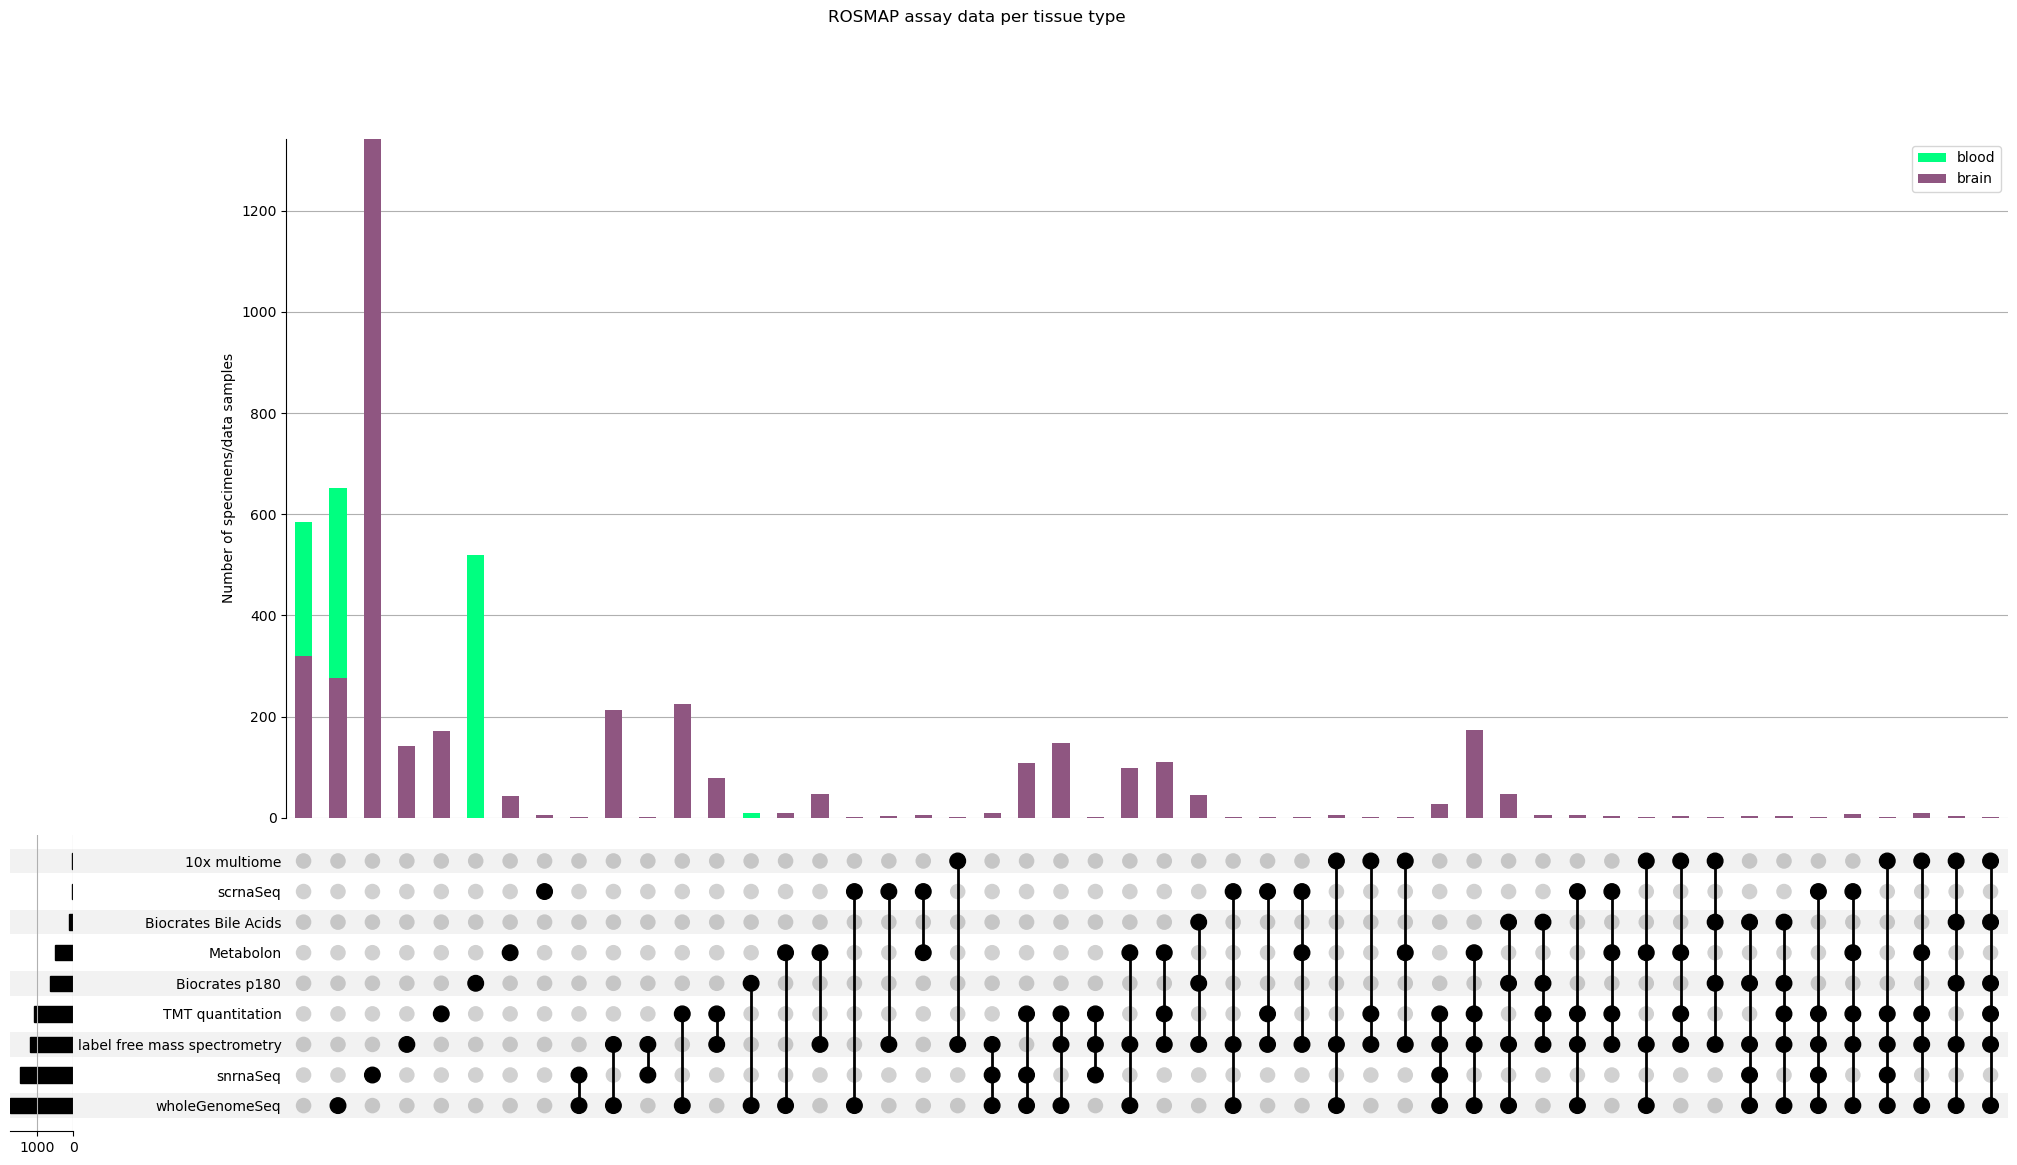

In [404]:
from matplotlib import cm
from matplotlib import pyplot as plt

from upsetplot import UpSet
from upsetplot import from_memberships
from upsetplot import plot

rosmap_ups = from_memberships(rosmap_gold_bio.assay.str.split(","), data=rosmap_gold_bio)

upset = UpSet(df, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="tissue", colors=ros_colors, title="Number of specimens/data samples", elements=20
)
upset.plot()


plt.suptitle("ROSMAP assay data per tissue type")
plt.savefig('ROSMAP_upset_plot.png')
plt.show()

In [200]:
rosmap_metabo_bio = rosmap_gold_bio[rosmap_gold_bio['assay'].isin( 
                                    ['Brain Biocrates bile acids', 'Brain Metabolon' , 
                                     'Brain Biocrates p180', 'Serum Biocrates p180', 
                                     'Plasma lipidomics (LC/MSMS)', 'Brain lipidomics (LC/MSMS)'])]
#rosmap_metabo_bio

#### Venn diagram with just the metabolomics categories

## End of ROSMAP-specific section

#### Recreate gold standard AMP-AD 1.0/2.0 biospecimen metadata

In [48]:
mega_bio = mega_bio[((mega_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (mega_bio['individualID'].str.lower().str.contains('gis') == False))]

In [49]:
mega_bio

,individualID,specimenID,dataGenerationSite,organ,tissue,BrodmannArea,isPostMortem,sampleStatus,nucleicAcidSource,assay,specimenMetadataSource,specimenIdSource,tissueWeight,tissueVolume,cellType,fastingState,samplingAge,samplingAgeUnits,visitNumber,exclude,excludeReason,samplingDate,Exclusion_Category
0,NYBB_17,NYBB_17WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NYBB_147,NYBB_147WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NYBB_148,NYBB_148WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NYBB_153,NYBB_153WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NYBB_76,NYBB_76WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23266,AMPAD_MSSM_0000009439,179091_NEU_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN+,NaN,NaN,years,NaN,False,NaN,NaN,NaN
23267,AMPAD_MSSM_0000009439,179091_OLIG_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN-_sox10+,NaN,NaN,years,NaN,False,NaN,NaN,NaN
23268,AMPAD_MSSM_0000068806,179321_MGAS_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN-_sox10-,NaN,NaN,years,NaN,False,NaN,NaN,NaN
23269,AMPAD_MSSM_0000068806,179321_NEU_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN+,NaN,NaN,years,NaN,False,NaN,NaN,NaN


#### 5/2 AMP-AD 1.0/2.0 summary by individualID

In [104]:
mega_bio = pd.concat([divco_bio, rosmap_gold_bio, mayo_bio, msbb_bio], ignore_index=True)
mega_bio['tissue'] = mega_bio['tissue'].apply(lambda x: tissue_to_category.get(x) if x 
                                              in tissue_to_category.keys() else x)

mega_bio = mega_bio[((mega_bio['individualID'].str.lower().str.contains('control') == False) & 
                                   (mega_bio['individualID'].str.lower().str.contains('gis') == False))]

# drop rows where there exists no individualID or specimenID
mega_bio

,individualID,specimenID,dataGenerationSite,organ,tissue,BrodmannArea,isPostMortem,sampleStatus,nucleicAcidSource,assay,specimenMetadataSource,specimenIdSource,tissueWeight,tissueVolume,cellType,fastingState,samplingAge,samplingAgeUnits,visitNumber,exclude,excludeReason,samplingDate,notes,dataContributionGroup,cohort,sex,race,isHispanic,ageDeath,PMI,apoeGenotype,amyThal,amyA,amyCerad,Braak,mayoDx,amyAny,bScore,reag,ADoutcome,derivedOutcomeBasedOnMayoDx,clinicalMetadataSource,individualID_AMPAD_1.0,Component_x,species,ethnicity,yearsEducation,diagnosis,diagnosisCriteria,ageDeathUnits,causeDeath,mannerDeath,pmiUnits,CERAD,brainWeight,pH,diverseCohortsIndividualIDFormat,individualMetadataSource,Component_y,Id,entityId,Exclusion_Category
0,NYBB_17,NYBB_17WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NYBB_147,NYBB_147WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NYBB_148,NYBB_148WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NYBB_153,NYBB_153WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NYBB_76,NYBB_76WGS,NYGC,brain,prefrontal cortex,BA9,True,frozen,bulk cell,wholeGenomeSeq,AMP-AD_DiverseCohorts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,AMPAD_MSSM_0000009439,179091_NEU_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN+,NaN,NaN,years,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29770,AMPAD_MSSM_0000009439,179091_OLIG_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN-_sox10+,NaN,NaN,years,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29771,AMPAD_MSSM_0000068806,179321_MGAS_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN-_sox10-,NaN,NaN,years,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29772,AMPAD_MSSM_0000068806,179321_NEU_rnaseq,NaN,brain,temporal cortex,36.0,True,frozen,sorted nuclei,rnaSeq,MSBB,NaN,NaN,NaN,NeuN+,NaN,NaN,years,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
